# **Image Classification using Convolutional Neural Network**

## Import Necessary Libraries

In [1]:
# Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
# Checking device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Using Kaggle API to Download Image Classification Data Set

In [3]:
from google.colab import files
import zipfile

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification 

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Open the zip file in read mode
zip_ref = zipfile.ZipFile('intel-image-classification.zip', 'r')
# Extract the files into the /content folder
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# Transform
transformer = transforms.Compose([
                                  transforms.Resize((150, 150)), # resize images into same dimensions
                                  transforms.RandomHorizontalFlip(p=0.5), # 50% of images will be flipped horizontally
                                  transforms.ToTensor(), # convert pixel range form 0-255 to 0-1 and numpy to tensor
                                  transforms.Normalize([0.5, 0.5, 0.5], # normalize from 0-1 to -1 to 1, formula = (x-mean)/std
                                                       [0.5, 0.5, 0.5]) # columns as RGB channels, rows as mean and std respectively
])

In [6]:
# Train and test paths
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'

batch_size = 256

# DataLoader
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(root=train_path, transform=transformer),
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(root=test_path, transform=transformer),
    batch_size=batch_size,
    shuffle=True
)

In [7]:
# Get root path to train data set
root = pathlib.Path(train_path)
print(root)

[print(j) for j in root.iterdir()]

/content/seg_train/seg_train
/content/seg_train/seg_train/forest
/content/seg_train/seg_train/mountain
/content/seg_train/seg_train/buildings
/content/seg_train/seg_train/street
/content/seg_train/seg_train/sea
/content/seg_train/seg_train/glacier


[None, None, None, None, None, None]

Realize that if we split the paths with respect to '/' as separators, we can get the categories as the last elements.

In [8]:
# Fetch categories
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Building Our Convolutional Network Model

In [9]:
# CNN Model
class ConvNet(nn.Module):
  def __init__(self, num_classes = len(classes)):
    super(ConvNet, self).__init__()

    # Input shape = (256, 3, 150, 150)
    # 256 = batch_size
    # 3 = RGB channels 
    # 150 x 150 = Image size
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    # Shape = (256, 12, 150, 150)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    # Shape = (256, 12, 150, 150)
    self.relu1 = nn.ReLU()
    # Shape = (256, 12, 150, 150)

    self.pool = nn.MaxPool2d(kernel_size=2)
    # Max Pooling reduces image size by factor of 2
    # Shape = (256, 12, 75, 75)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
    # Shape = (256, 20, 75, 75)
    self.relu2 = nn.ReLU()
    # Shape = (256, 20, 75, 75)

    self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
    # Shape = (256, 32, 75, 75)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    # Shape = (256, 32, 75, 75)
    self.relu3 = nn.ReLU()
    # Shape = (256, 32, 75, 75)

    self.fc = nn.Linear(in_features=32*75*75, out_features=num_classes)

  # Feed forward pass function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.relu3(output)

    # Above output will be in matrix form with shape (256, 32, 75, 75)
    output = output.view(-1, 32*75*75)

    output = self.fc(output)
    return output

In [10]:
model = ConvNet(num_classes=len(classes)).to(device)

In [11]:
learning_rate = 0.001

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [12]:
# Calculate size of training and testing images
train_count = len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))

In [13]:
print(train_count, test_count)

14034 3000


## Training Our Model

In [14]:
# Model training and saving best model
num_epochs = 10
best_accuracy = 0.0

for epoch in range(num_epochs):
  
  # Training and evaluation on training data set
  model.train()
  train_accuracy = 0.0
  train_loss = 0.0

  for (images, labels) in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backpropagation
    loss.backward()

    # Update
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.cpu().data * images.size(0)
    _, prediction = torch.max(outputs.data, 1)

    train_accuracy +=  int(torch.sum(prediction == labels.data))

  train_accuracy /= train_count
  train_loss /= train_count

  # Evaluation on testing data set
  model.eval()

  test_accuracy = 0.0
  
  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, prediction = torch.max(outputs.data, 1)

    test_accuracy += int(torch.sum(prediction == labels.data))

  test_accuracy /= test_count

  print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

  # Save the best model
  if test_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = test_accuracy

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Training Loss: 7.8563, Training Accuracy: 0.5505, Test Accuracy: 0.5883
Epoch: 1, Training Loss: 1.5505, Training Accuracy: 0.7172, Test Accuracy: 0.7413
Epoch: 2, Training Loss: 0.9791, Training Accuracy: 0.7744, Test Accuracy: 0.6450
Epoch: 3, Training Loss: 0.8626, Training Accuracy: 0.7952, Test Accuracy: 0.7007
Epoch: 4, Training Loss: 0.5556, Training Accuracy: 0.8572, Test Accuracy: 0.7300
Epoch: 5, Training Loss: 0.3794, Training Accuracy: 0.8940, Test Accuracy: 0.7017
Epoch: 6, Training Loss: 0.3593, Training Accuracy: 0.9057, Test Accuracy: 0.7693
Epoch: 7, Training Loss: 0.2445, Training Accuracy: 0.9299, Test Accuracy: 0.7330
Epoch: 8, Training Loss: 0.1558, Training Accuracy: 0.9473, Test Accuracy: 0.7730
Epoch: 9, Training Loss: 0.1281, Training Accuracy: 0.9602, Test Accuracy: 0.7387


## Evaluating Our Model

In [15]:
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
from PIL import Image
import cv2

In [16]:
pred_path = '/content/seg_pred/seg_pred'

In [17]:
# Load best checkpoint from training
checkpoint = torch.load('best_checkpoint.model')
model = ConvNet(num_classes=len(classes)).to(device)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [18]:
transformer = transforms.Compose([
                                  transforms.Resize((150, 150)), # resize images into same dimensions
                                  transforms.ToTensor(), # convert pixel range form 0-255 to 0-1 and numpy to tensor
                                  transforms.Normalize([0.5, 0.5, 0.5], # normalize from 0-1 to -1 to 1, formula = (x-mean)/std
                                                       [0.5, 0.5, 0.5]) # columns as RGB channels, rows as mean and std respectively
])

In [24]:
# Prediction function
def prediction(img_path, transformer):

  image = Image.open(img_path)
  image_tensor = transformer(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  
  image_tensor = image_tensor.to(device)
  input = Variable(image_tensor)

  output = model(input)

  # Get index of highest probability and index the classes list to get predicted class
  index = output.cpu().data.numpy().argmax()
  pred = classes[index] 
  return pred

In [20]:
images_path = glob.glob(pred_path + '/*.jpg')
images_path[:10]

['/content/seg_pred/seg_pred/2139.jpg',
 '/content/seg_pred/seg_pred/19618.jpg',
 '/content/seg_pred/seg_pred/20902.jpg',
 '/content/seg_pred/seg_pred/13950.jpg',
 '/content/seg_pred/seg_pred/13062.jpg',
 '/content/seg_pred/seg_pred/11248.jpg',
 '/content/seg_pred/seg_pred/12139.jpg',
 '/content/seg_pred/seg_pred/11485.jpg',
 '/content/seg_pred/seg_pred/7707.jpg',
 '/content/seg_pred/seg_pred/23751.jpg']

In [25]:
pred_dict = {}

for i in images_path:
  pred_dict[i[i.rfind('/') + 1:]] = prediction(i, transformer)

In [26]:
# View predictions
pred_dict

{'2139.jpg': 'forest',
 '19618.jpg': 'glacier',
 '20902.jpg': 'sea',
 '13950.jpg': 'street',
 '13062.jpg': 'mountain',
 '11248.jpg': 'glacier',
 '12139.jpg': 'sea',
 '11485.jpg': 'mountain',
 '7707.jpg': 'glacier',
 '23751.jpg': 'forest',
 '22274.jpg': 'street',
 '19109.jpg': 'forest',
 '17158.jpg': 'sea',
 '5839.jpg': 'street',
 '6688.jpg': 'glacier',
 '3335.jpg': 'mountain',
 '12781.jpg': 'street',
 '3696.jpg': 'glacier',
 '16892.jpg': 'forest',
 '22151.jpg': 'mountain',
 '4783.jpg': 'sea',
 '8429.jpg': 'forest',
 '4542.jpg': 'buildings',
 '21616.jpg': 'buildings',
 '15302.jpg': 'mountain',
 '23198.jpg': 'glacier',
 '11763.jpg': 'buildings',
 '22323.jpg': 'sea',
 '9424.jpg': 'forest',
 '14787.jpg': 'glacier',
 '9556.jpg': 'glacier',
 '3093.jpg': 'glacier',
 '4746.jpg': 'mountain',
 '20877.jpg': 'forest',
 '17832.jpg': 'glacier',
 '21223.jpg': 'mountain',
 '7536.jpg': 'street',
 '16541.jpg': 'street',
 '4278.jpg': 'mountain',
 '881.jpg': 'glacier',
 '6162.jpg': 'sea',
 '7130.jpg': 'mo

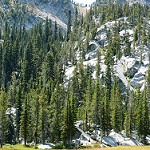

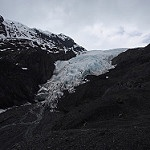

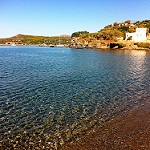

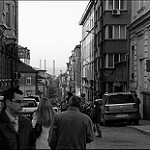

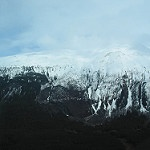

In [32]:
from google.colab.patches import cv2_imshow

# Let's view the some images from the pred folder and see if the predictions made above are right
img_paths = ['/content/seg_pred/seg_pred/2139.jpg',   # forest
             '/content/seg_pred/seg_pred/19618.jpg',   # glacier
             '/content/seg_pred/seg_pred/20902.jpg',   # sea
             '/content/seg_pred/seg_pred/13950.jpg',   # street
             '/content/seg_pred/seg_pred/13062.jpg']  # mountain

for i in img_paths:
  img = cv2.imread(i)
  cv2_imshow(img)